In [47]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd

### INPUT

In [48]:
# satellite/sensor info
sat_ind = 'S2B'  # satellite sign  # <===== fill
sensor_ind = 'MSI'  # sensor sign

# AC info
software = 'ACOLITE'  # <===== fill
suit = 'ACOLITE'  # <===== fill

date_exp = '2018-07-03'  # <===== fill
date_sat = '2018-07-03'  # <===== fill

# ------------------------   path to data
exp_dir = f'/media/data1/laboratory/measurements/{date_exp[:4]}/{date_exp[5:7]}-{date_exp[:4]}/'
sat_dir = f'/media/data1/laboratory/results/{date_exp[:4]}/{date_exp[5:7]}-{date_exp[:4]}/{software}/'
#exp_dir = f'/home/s-f/laboratory/measurements/{date_exp[:4]}/{date_exp[5:7]}-{date_exp[:4]}/'
#sat_dir = f'/home/s-f/laboratory/results/{date_exp[:4]}/{date_exp[5:7]}-{date_exp[:4]}/{software}/'

# nc file
#nc_name = '/media/data1/acolite_py_linux/output/gorky_S2_20180703/S2B_MSI_2018_07_03_08_34_00_T38VLH_L2W.nc'  # <===== fill
nc_name = f'/home/s-f/laboratory/results/{date_exp[:4]}/test-02/S2B_MSI_2018_07_03_08_34_00_T38VLH_L2W.nc'

# expedition data
#exp_name = '/home/s-f/Downloads/Sentinel-2/Rrs_2018-08-02.csv'
exp_name = exp_dir + f'Rrs_{date_exp}.csv'

# station coordinates: must have Name, X, Y
coord_name = sat_dir + f'coord_{date_sat}.csv'  


# !!!! SRF file must be in current directory !!!!
#  !!!! measurements must be in range 378-760 nm - other cases did not test
SRF_name = f'{sat_ind} {sensor_ind} SRF.csv'


# ----------------------  Validation type (in_pixel or in_box)
# flag to switch for in_pixel or in_box validation
in_pixel = False  # <===== fill

# function for validation = minimum absolute error
def minAE(x, x1):
    result = []
    for i, item in enumerate(x):
        result += [sorted(item, key=lambda item: np.abs(item - x1[i]))[0]]
    return result

# select function for comparision with satellite data
func =minAE  # <===== fill
func_id = 'minAE3' # <===== fill
# func_id = func and boxsize

# box size for avareging satellite data
box_size = 3  # <===== fill
if in_pixel:
    dx = 0
else:
    dx = box_size // 2  # +/- limits of box
    
# which station dont count in validation
del_station = []   # <===== fill

## Read expedition data and transform them to satellite bands

In [49]:
# read in situ radiometry: index = wavelength, columns = measurements
radiom = pd.read_csv(exp_name, index_col=0, sep='\t')

#station_quantity = radiom.shape[1]  # measurments amount

# drop stations where no measurments
#radiom = radiom.dropna(axis=1, how='all')
#radiom = radiom / np.pi  # reflectance to Rrs

# read SRF of satellite sensor
srf = pd.read_csv(SRF_name, index_col=0, sep='\t')

# transform insitu hyperspectral measurements to satellite bands
if sat_ind == 'S2A':
    wavelength = [443, 492, 560, 665, 704, 740]
elif sat_ind == 'S2B':
    wavelength = [442, 492, 559, 665, 704, 739]
    
# create DataFrame and fill it: index = measurements, columns = Rrs in spectral bands
radiom_band = pd.DataFrame(np.full((radiom.columns.size, len(wavelength)), np.nan), columns=wavelength, \
                           index=range(1, radiom.columns.size + 1), dtype=np.float64)
for column in radiom.columns:
    if not np.any(radiom[column].isna()):
        radiom_band.loc[int(column)] = [round((radiom[column] * srf[col]).sum() / srf[col].sum(), 8) for col in srf.columns]

## Read coordinates of stations

In [50]:
station_coords = pd.read_csv(coord_name, index_col=0, sep='\t')

## Read satellite data

In [51]:
sat_file = Dataset(nc_name)  # nc file dataset
print(*sat_file.variables)

lon lat Rrs_442 Rrs_492 Rrs_559 Rrs_665 Rrs_704 Rrs_739 l2_flags


In [52]:
rrs_names = [item for item in sat_file.variables if item.startswith('Rrs_')]  # list of Rrs_bands

In [53]:
#if in_pixel:


In [54]:
# create Dataframe: index = measurements, columns = spectral bands
sat_data = pd.DataFrame(columns=rrs_names, index=station_coords.index, dtype=np.float64)

for i, rrs_name in enumerate(rrs_names):
    # values in box for spectral band
    box_values = [sat_file.variables[rrs_name][int(y)-dx:int(y)+dx+1, int(x)-dx:int(x)+dx+1].flatten() for y, x in zip(station_coords.Y, station_coords.X)]
    
     # fill Dataframe columns
    if func is minAE:
        sat_data[rrs_name] = func(box_values, radiom_band[wavelength[i]].to_list())
    else:
        sat_data[rrs_name] = func(box_values, axis=1)

# drop stations where no measurments        
sat_data = sat_data.dropna(axis=0, how='all')

In [55]:
sat_file.close()

## Calculate and plot validation accuracy parameters

In [56]:
import matplotlib.pyplot as plt

In [57]:
# joint Dataframe
combo = pd.concat([radiom_band, sat_data], axis=1).dropna(axis=0, how='any')

In [58]:
#station for deletion

if del_station:
    combo.drop(labels=del_station, axis=0, inplace=True)

In [59]:
combo

,442,492,559,665,704,739,Rrs_442,Rrs_492,Rrs_559,Rrs_665,Rrs_704,Rrs_739
1,0.002741,0.004390,0.007305,0.007862,0.008526,0.005506,0.004515,0.004371,0.004704,0.003785,0.003824,0.003324
2,0.003019,0.005306,0.009718,0.008473,0.011139,0.007230,0.004982,0.005198,0.006600,0.004870,0.006219,0.004969
3,0.001138,0.005333,0.014963,0.008464,0.018901,0.013611,0.004561,0.004463,0.005225,0.004025,0.004313,0.003916
4,0.002452,0.004259,0.007628,0.007727,0.008530,0.004512,0.004838,0.004496,0.007163,0.004936,0.007133,0.004791
5,0.002133,0.003966,0.007538,0.008324,0.008853,0.004999,0.004725,0.004131,0.005439,0.004580,0.004449,0.003947
6,0.002824,0.004562,0.008138,0.009307,0.009820,0.006122,0.004754,0.004507,0.005626,0.004297,0.004800,0.004716
7,0.002619,0.004714,0.008917,0.009311,0.010635,0.006007,0.004563,0.004669,0.005212,0.004194,0.004449,0.003737
8,0.002188,0.004373,0.008542,0.008911,0.010174,0.005705,0.004580,0.004373,0.005294,0.004232,0.004381,0.003598
9,0.002368,0.004267,0.007830,0.008192,0.008800,0.004434,0.004385,0.004264,0.004688,0.003848,0.003782,0.003424
10,0.002296,0.004333,0.007916,0.008590,0.008962,0.004252,0.004565,0.004351,0.004884,0.004026,0.004208,0.003916


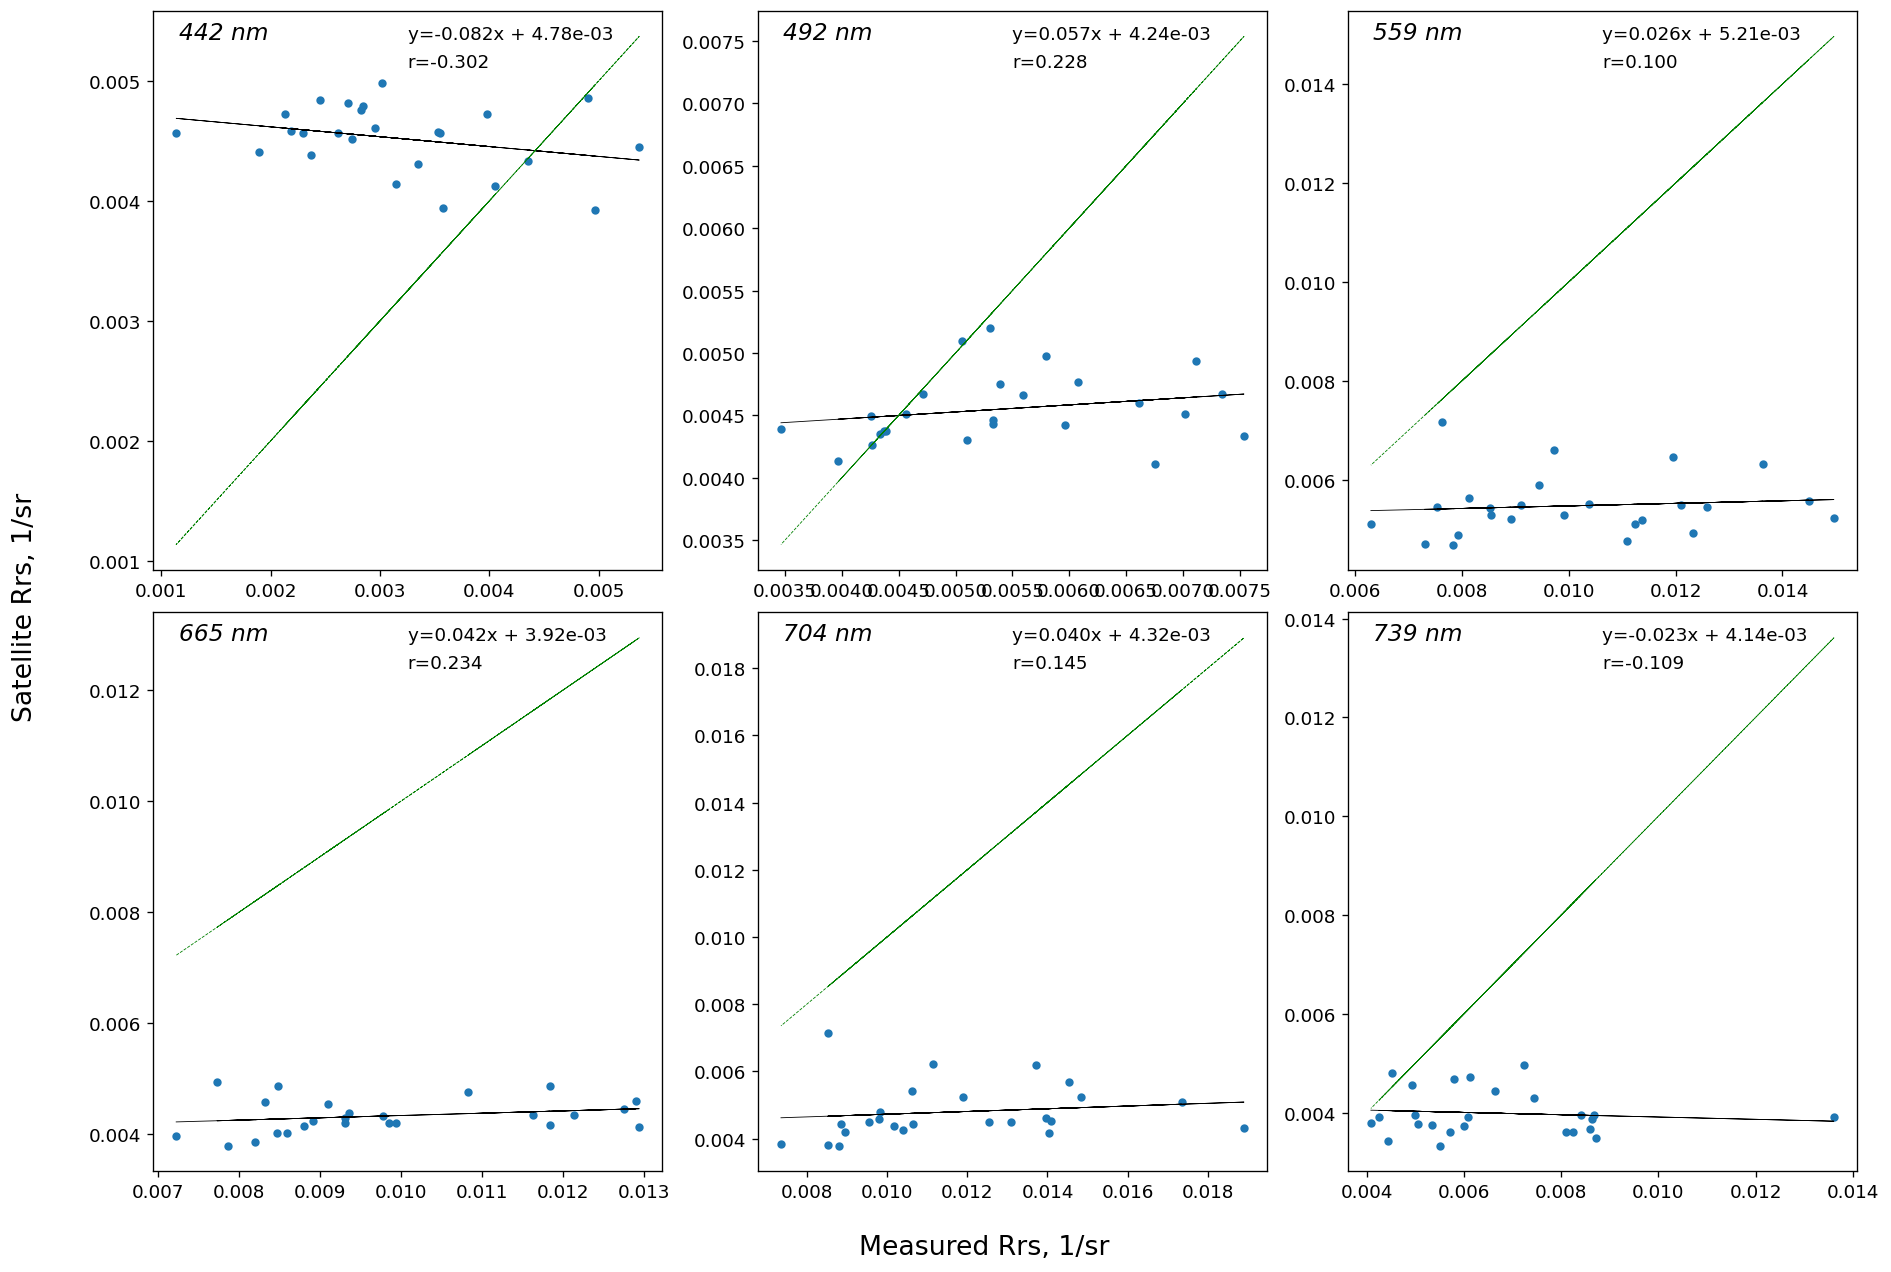

In [60]:
#calculate and plot in cycle for all bands
fig,axs = plt.subplots(figsize = (15,10), dpi=120, ncols=3, nrows=2, constrained_layout=True)


res = []
for col, ax in zip(wavelength, axs.flatten()):
    x = combo[col]
    y = combo[f'Rrs_{col}']

    lin_reg = np.polyfit(x, y, 1)
    pearson = np.corrcoef(x, y)[0,1]
    trend = np.polyval(lin_reg, x)
    bias = (y - x).sum() / x.size
    mape = (np.fabs(y - x)/x).sum() / x.size * 100
    rmse = (((y - x)**2).sum() / x.size)**0.5

    ax.plot(x, y, 'o', x, trend,  '-k', lw=0.5, ms=4) 
    ax.plot(x, x, '--g', lw=0.5)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
    ax.text(0.05, 0.95, f"{col} nm", transform=ax.transAxes, fontsize=14, fontstyle='italic')
    ax.text(0.5, 0.95, "y={0:.3f}x + {1:.2e}".format(*lin_reg), transform=ax.transAxes, fontsize=11)
    ax.text(0.5, 0.9, "r={:.3f}".format(pearson), transform=ax.transAxes, fontsize=11)
    
    res.append([round(lin_reg[0], 4), round(lin_reg[1], 4), round(pearson, 3), round(rmse, 4), round(bias, 4)])
    
fig.text(0.5, -0.04, 'Measured Rrs, 1/sr', ha='center', fontsize=16)
fig.text(-0.04, 0.5, 'Satellite Rrs, 1/sr', va='center', rotation='vertical', fontsize=16)


plt.savefig(f'scatterplots_{software}_{date_sat}_{func_id}.png')
#plt.show()

In [61]:
# print and save table with accuracy parameters in file
accur = pd.DataFrame(res, index=wavelength, columns=['slope', 'intercept', 'r', 'rmse', 'bias']).T
fname = f'accuracy_{software}_{date_sat}_{func_id}.csv'
accur.to_csv(fname, sep='\t')
accur

,442,492,559,665,704,739
slope,-0.0821,0.0565,0.0257,0.0416,0.0404,-0.0233
intercept,0.0048,0.0042,0.0052,0.0039,0.0043,0.0041
r,-0.3020,0.2280,0.1000,0.2340,0.1450,-0.1090
rmse,0.0018,0.0014,0.0052,0.0058,0.0075,0.0035
bias,0.0014,-0.0009,-0.0046,-0.0055,-0.0069,-0.0027


In [62]:
combo.T[:5]

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
442,0.002741,0.003019,0.001138,0.002452,0.002133,0.002824,0.002619,0.002188,0.002368,0.002296,...,0.002955,0.004897,0.005370,0.004349,0.004967,0.003574,0.004055,0.003143,0.003552,0.001899
492,0.004390,0.005306,0.005333,0.004259,0.003966,0.004562,0.004714,0.004373,0.004267,0.004333,...,0.005795,0.007346,0.007538,0.006618,0.006752,0.005963,0.007020,0.005390,0.005103,0.003463
559,0.007305,0.009718,0.014963,0.007628,0.007538,0.008138,0.008917,0.008542,0.007830,0.007916,...,0.011952,0.012592,0.012333,0.012107,0.011091,0.011363,0.014491,0.010377,0.008524,0.006293
665,0.007862,0.008473,0.008464,0.007727,0.008324,0.009307,0.009311,0.008911,0.008192,0.008590,...,0.010828,0.012138,0.012941,0.012748,0.011836,0.011626,0.012901,0.009931,0.008804,0.007221
704,0.008526,0.011139,0.018901,0.008530,0.008853,0.009820,0.010635,0.010174,0.008800,0.008962,...,0.013705,0.013951,0.014049,0.014826,0.013081,0.014099,0.017344,0.011901,0.009548,0.007355


In [63]:
# print and save table with data in file
combo.columns = pd.MultiIndex.from_product([['Measurements', 'Satellite'], wavelength])
fname = f'measured_{software}_{date_sat}_{func_id}.csv'
combo.to_csv(fname, sep='\t', float_format="%.6f")
combo.head()

Measurements                                                   Satellite  \
           442       492       559       665       704       739       442   
1     0.002741  0.004390  0.007305  0.007862  0.008526  0.005506  0.004515   
2     0.003019  0.005306  0.009718  0.008473  0.011139  0.007230  0.004982   
3     0.001138  0.005333  0.014963  0.008464  0.018901  0.013611  0.004561   
4     0.002452  0.004259  0.007628  0.007727  0.008530  0.004512  0.004838   
5     0.002133  0.003966  0.007538  0.008324  0.008853  0.004999  0.004725   

                                                     
        492       559       665       704       739  
1  0.004371  0.004704  0.003785  0.003824  0.003324  
2  0.005198  0.006600  0.004870  0.006219  0.004969  
3  0.004463  0.005225  0.004025  0.004313  0.003916  
4  0.004496  0.007163  0.004936  0.007133  0.004791  
5  0.004131  0.005439  0.004580  0.004449  0.003947

<AxesSubplot:>

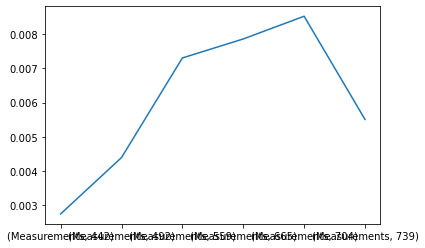

In [64]:
combo.T.iloc[:6,0].plot()

<AxesSubplot:>

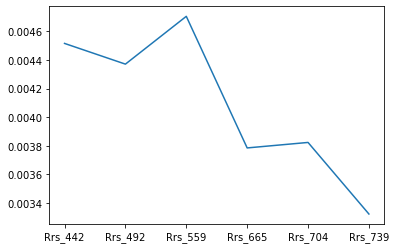

In [65]:
sat_data.T.iloc[:,0].plot()

In [66]:
combo.T.iloc[:6]

1         2         3         4         5         6   \
Measurements 442  0.002741  0.003019  0.001138  0.002452  0.002133  0.002824   
             492  0.004390  0.005306  0.005333  0.004259  0.003966  0.004562   
             559  0.007305  0.009718  0.014963  0.007628  0.007538  0.008138   
             665  0.007862  0.008473  0.008464  0.007727  0.008324  0.009307   
             704  0.008526  0.011139  0.018901  0.008530  0.008853  0.009820   
             739  0.005506  0.007230  0.013611  0.004512  0.004999  0.006122   

                        7         8         9         10  ...        17  \
Measurements 442  0.002619  0.002188  0.002368  0.002296  ...  0.002955   
             492  0.004714  0.004373  0.004267  0.004333  ...  0.005795   
             559  0.008917  0.008542  0.007830  0.007916  ...  0.011952   
             665  0.009311  0.008911  0.008192  0.008590  ...  0.010828   
             704  0.010635  0.010174  0.008800  0.008962  ...  0.013705   
             739  0.006007  0.005705  0.004434  0.004252  ...  0.006631   

                        18        19        20        21        22        23  \
Measurements 442  0.004897  0.005370  0.004349  0.004967  0.003574  0.004055   
             492  0.007346  0.007538  0.006618  0.006752  0.005963  0.007020   
             559  0.012592  0.012333  0.012107  0.011091  0.011363  0.014491   
             665  0.012138  0.012941  0.012748  0.011836  0.011626  0.012901   
             704  0.013951  0.014049  0.014826  0.013081  0.014099  0.017344   
             739  0.008249  0.008706  0.008639  0.008108  0.008590  0.008682   

                        24        25        26  
Measurements 442  0.003143  0.003552  0.001899  
             492  0.005390  0.005103  0.003463  
             559  0.010377  0.008524  0.006293  
             665  0.009931  0.008804  0.007221  
             704  0.011901  0.009548  0.007355  
             739  0.006083  0.005347  0.004083  

[6 rows x 25 columns]

In [67]:
combo.T.iloc[:6,0]

Measurements  442    0.002741
              492    0.004390
              559    0.007305
              665    0.007862
              704    0.008526
              739    0.005506
Name: 1, dtype: float64

In [68]:
a = combo.index.values

IndexError: single positional indexer is out-of-bounds

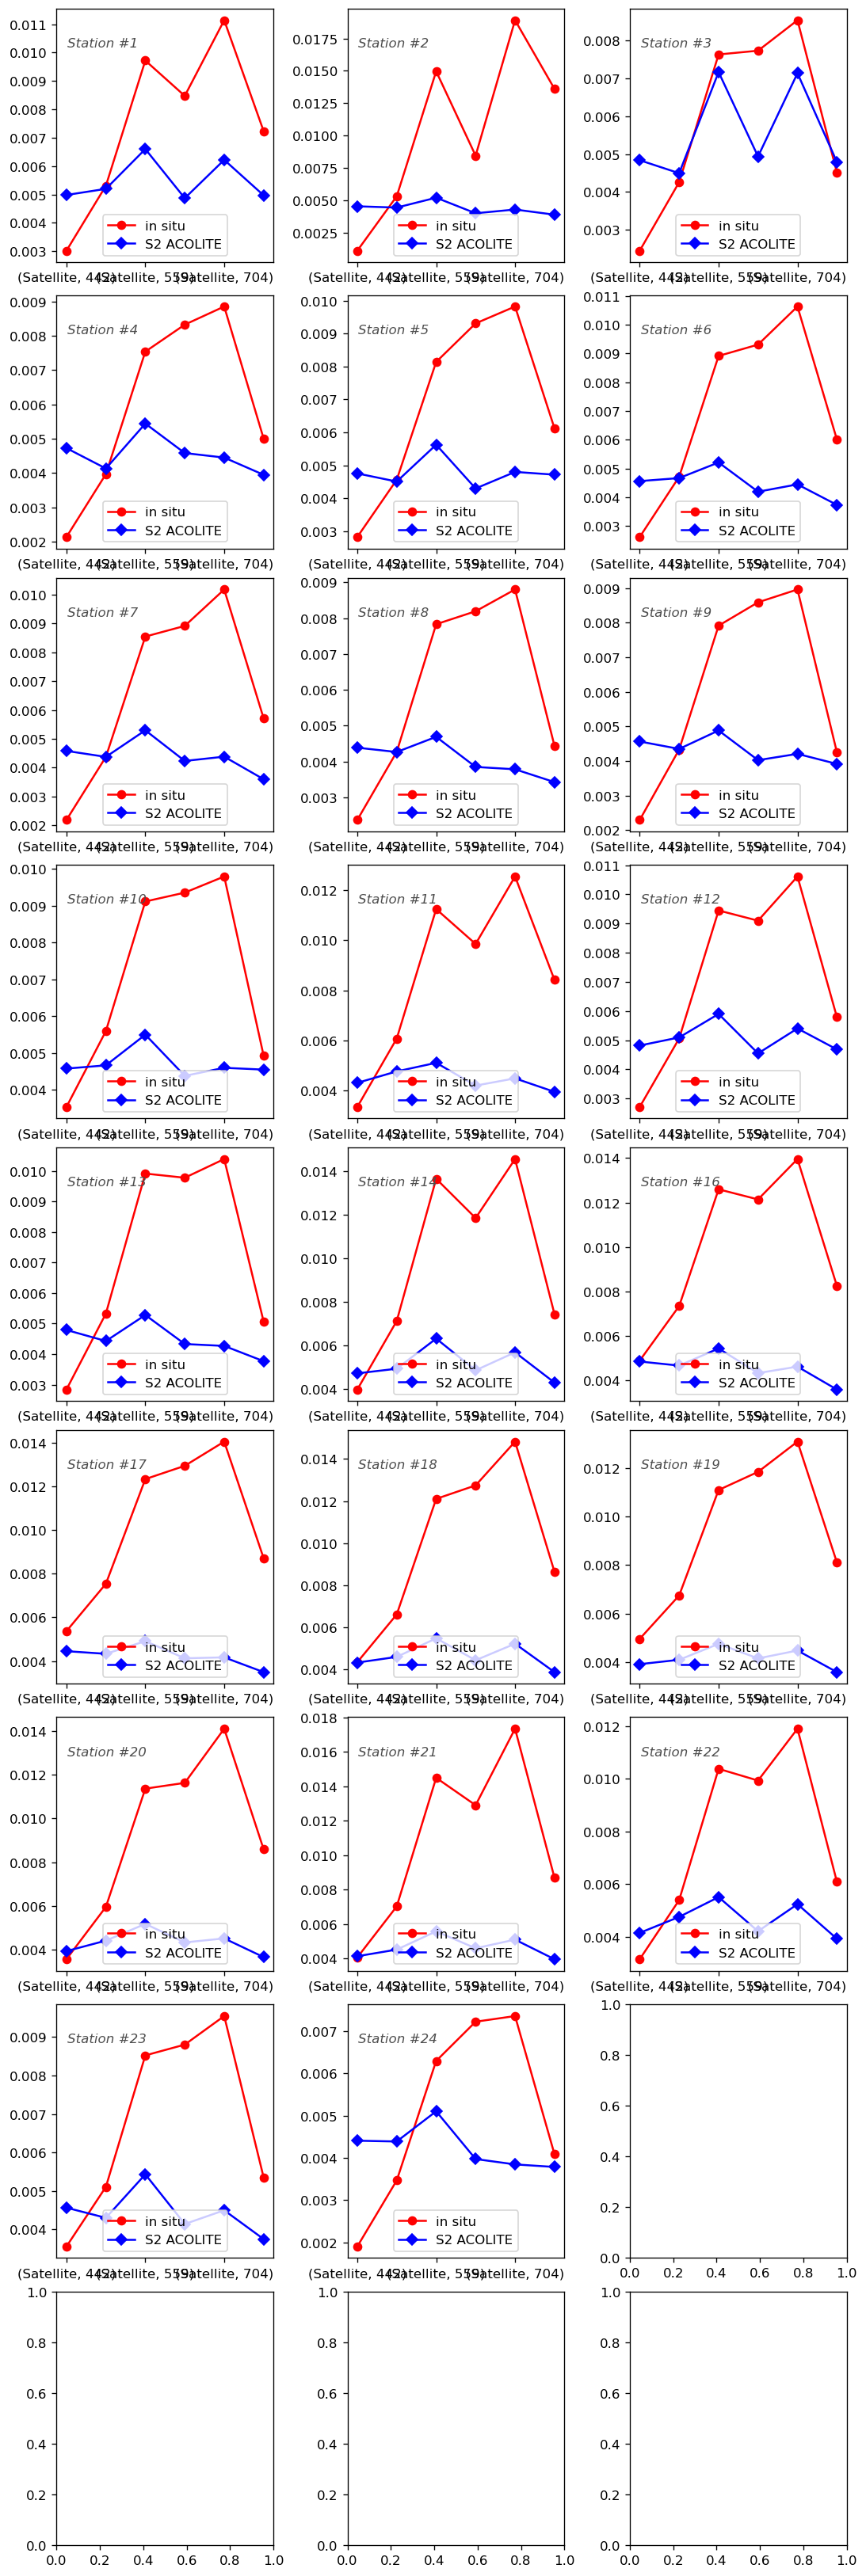

In [69]:
fig,axs = plt.subplots(figsize = (9,27), dpi=120, ncols=3, nrows=combo.shape[0]//3 + 1, constrained_layout=True)

for col, ax in zip(combo.index.values, axs.flatten()):
    #x = combo.T.iloc[:6, col]
    #y = combo[f'Rrs_{col}']
    #plt.figure();
   
    combo.T.iloc[:6, col].plot(legend=True, label='in situ', color='red', marker='o', ax=ax)
    combo.T.iloc[6:, col].plot(legend=True, label='S2 ACOLITE', color='blue', marker='D', ax=ax).legend(loc="lower center")
    ax.annotate(f'Station #{col}', (0.05,0.85),
         xycoords='axes fraction',fontsize=10,style='italic',color='0.3')

In [ ]:
for a,b in zip(combo.index, combo.index.values):
    print(a,b)

In [ ]:
combo